## Development-Kit Tutorial for Zenseact Open Dataset
This notebook aims to introduce the ZodFrames & ZodSequences classes, which are helper classes to interact with the Frames and Sequences subsets of the Zenseact Open Dataset (ZOD) respecively. It will highlight some basic functionality that later can be used to build dataloaders in for example PyTorch.

This notebook also aims to give a brief introduction to the which annotations exist and how to visualization them. 

#### The dataset includes data from 3 sensor modalities and calibrations for each sensor:  
1. **Camera** - Anonymized (license plates and faces) front camera images. Available anonymization methods are:
    - blur (Blur)
    - dnat (Deep Fake)


2. **LiDAR** - The LiDAR point cloud is the closest LiDAR scan to the camera timestamp of the core frame. Zenseact Open Dataset also provides a range of LiDAR point clouds captured in [-1s, +1s] at 10Hz around the core frame for the sequences.


3. **OXTS** - High-precision GPS. OXTS data is provided in [-1s, ~10s] around the core frames for each sequence.

#### There are 4 types of annotationed objects:  
1. **dynamic_objects** - objects that can move (vehicles, pedestrians etc.) - annotated with 2D/3D bounding boxes
2. **static_objects** - non-movable objects (light poles, traffic signs etc.) - annotated with 2D/3D bounding boxes
3. **lane_markings** - lane markings and road paitings - annotated with polygons
4. **ego_road** (Doesn't exist for all frames) - polygons that shows the road where ego vehicle can drive - annotated with polygons 

# Initialization


In [ ]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

from typing import List

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

# import the ZOD DevKit
from zod import ZodFrames
from zod import ZodSequences

# import default constants
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject

# import useful data classes
from zod.data_classes import LidarData

# NOTE! Set the path to dataset and choose a version
dataset_root = "/media/rlab10/Dataset/zod"  # your local path to zod
version = "full"  # "mini" or "full"

# initialize ZodFrames
zod_frames = ZodFrames(dataset_root=dataset_root, version=version)

# initialize ZodSequences
#zod_sequences = ZodSequences(dataset_root=dataset_root, version=version) # NOTE! I don't use Sequences in my case

### Split into Training and Validation sets

In [ ]:
# get default training and validation splits
training_frames = zod_frames.get_split(constants.TRAIN)
validation_frames = zod_frames.get_split(constants.VAL)

# print the number of training and validation frames
print(f"Number of training frames: {len(training_frames)}")
print(f"Number of validation frames: {len(validation_frames)}")

#training_sequences = zod_sequences.get_split(constants.TRAIN) # NOTE! I don't use Sequences in my case
#validation_sequences = zod_sequences.get_split(constants.VAL) # NOTE! I don't use Sequences in my case
#print(f"Number of training sequences: {len(training_sequences)}")
#print(f"Number of validation sequences: {len(validation_sequences)}")

# print out the first 5 training frames
print("The 5 first training frames have the ids:", sorted(list(training_frames))[:5])

# show the first training sequence
#rint("The first training sequence has the id:", sorted(list(training_sequences))[0]) # NOTE! I don't use Sequences in my case

# ZodFrames
### Fetch a ZodFrame
The ZodFrames class yield a `ZodFrame` which acts a cache for the light-weight data (e.g., ego-motion, calibration, and metadata), but also holds an `info` attribute. This in turn holds all the paths to more heavy-weight data (e.g., images and point clouds).


In [ ]:
# we can get a specific frame by its id
frame_from_id = zod_frames["009158"]
# or via the index
frame_from_idx = zod_frames[9158]

# these two frames are the same
assert frame_from_id.info == frame_from_idx.info

### Look at some data within a ZodFrame

In [ ]:
zod_frame = zod_frames[62592]

# we can access the metadata of a frame
metadata = zod_frame.metadata

# print a subsample of meta data
print(f"Frame id: {metadata.frame_id}")
print(f"Country Code: {metadata.country_code}")
print(f"Time of day: {metadata.time_of_day}")
print(f"Number of vehicles in the frame: {metadata.num_vehicles}")

# Custom Code
from time import sleep
from tqdm.notebook import tqdm
import pandas as pd
from scipy.spatial import KDTree
    
def get_frame_by_country(zod_frames, country_code="DE"):
    """Get all franes from a specific country."""
    german_frames = []
    for zod_frame in zod_frames:
        if zod_frame.metadata.country_code == country_code:
            german_frames.append(zod_frame.info.id)
    return german_frames

geonames = pd.read_csv("/home/rlab10/zod/DE.txt", sep="\t", header=None,
                       names=["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude",
        "feature_class", "feature_code", "country_code", "cc2", "admin1_code",
        "admin2_code", "admin3_code", "admin4_code", "population", "elevation",
        "dem", "timezone", "modification_date"],
        dtype={"latitude": float, "longitude": float}
)

coords = geonames[["latitude", "longitude"]].values
tree = KDTree(coords)

def get_nearest_place(lat, lon, max_dist_km=2):
    max_dist_deg = max_dist_km / 111.0
    dist, idx = tree.query([lat, lon], distance_upper_bound=max_dist_deg)
    if idx < len(geonames):
        return geonames.iloc[idx]["name"]
    return None

german_frames = get_frame_by_country(zod_frames, country_code="DE")
print("\nCustom Code:")
print(f"Number of German frames: {len(german_frames)}")

unique_cities = set()
city_counts = {}
ka_count = 0
for frame_id in tqdm(german_frames, desc="Processing german frames"):
    frame = zod_frames[frame_id]
    city = get_nearest_place(frame.metadata.latitude, frame.metadata.longitude)
    if city:
        unique_cities.add(city)
        if any(x in city for x in ["Karlsruhe", "Bruchsal", "Ettlingen", "Rheinstetten", "Durlach", "Knielingen", "Weingarten", 
                                   "Pfinztal", "Waldbronn", "Rüppurr", "Au am Rhein", "Hagenbach", "Neuburg am Rhein",
                                   "Wörth am Rhein", "Jockgrim", "Mühlburg"]):
            ka_count += 1

print(f"Found german cities: {len(unique_cities)}")
print(f"Frames in Karlsruhe surrounding: {ka_count}")

In [ ]:
# NOTE! I don't use OXTS in my case
# we can use the frame to get the OXTS of our the vehicle
#oxts = zod_frame.oxts
#print(f"Acceleration: {oxts.accelerations.shape}")
#print(f"Velocities: {oxts.velocities.shape}")
#print(f"Poses: {oxts.poses.shape}")
#print(f"Timestamps: {oxts.timestamps.shape}")

In [ ]:
# we can use the frame to get the ego-motion of our the vehicle
# note that the ego-motion is a lightweight version of the oxts data
ego_motion = zod_frame.ego_motion
print(f"Acceleration: {ego_motion.accelerations.shape}")
print(f"Velocities: {ego_motion.velocities.shape}")
print(f"Poses: {ego_motion.poses.shape}")
print(f"Timestamps: {ego_motion.timestamps.shape}")

In [ ]:
# The upper-left 3x3 matrix is the rotation matrix
rotation_matrix = zod_frame.ego_motion.poses[0, :3, :3]
print(rotation_matrix)

# The last column contain the translation
translation = zod_frame.ego_motion.poses[0, :3, -1]
print(translation)

In [ ]:
# we can also get the calibrations
calibrations = zod_frame.calibration

print(calibrations.lidars[Lidar.VELODYNE])
print(calibrations.cameras[Camera.FRONT])

#### Camera Data 

In [ ]:
# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.BLUR) # NOTE! I prefer BLUR over DNAT
print(camera_core_frame)

In [ ]:
# one can read the image from the filepath
image = camera_core_frame.read()
# or use a helper directly from the frame
image = zod_frame.get_image(Anonymization.BLUR) # NOTE! I prefer BLUR over DNAT

plt.axis("off")
plt.imshow(image)
plt.show()

#### Ego Position Data

In [ ]:
# NOTE! I don't use OXTS in my case
#from zod.visualization.oxts_on_image import visualize_oxts_on_image

#zod_frame = zod_frames["082291"]

# extract the oxts data
#oxts = zod_frame.oxts

# visualize the oxts data on the image
#calibrations = zod_frame.calibration

# get the time of the keyframe (into which we want to project the oxts points)
#key_timestamp = zod_frame.info.keyframe_time.timestamp()

#image = zod_frame.get_image(Anonymization.DNAT)
#image = visualize_oxts_on_image(oxts, key_timestamp, calibrations, image, camera=Camera.FRONT)

#plt.axis("off")
#plt.imshow(image)
#plt.show()

#### LiDAR Data
Lidar fields description:

| Name | Type | Units | Description |
| --- | --- | --- | --- |
| 'timestamp' | string |  seconds  | UTC timestamp of each point. |
| 'x' | double |  meters  | x coordinate of the point in lidar frame |
| 'y' | double |  meters  | y coordinate of the point in lidar frame |
| 'z' | double |  meters  | z coordinate of the point in lidar frame |
| 'intensity' | double |    | intensity level of each point in range [0..255] |
| 'diode_index' | integer |    | index of diode emitter which produced a point (1..128) |

In [ ]:
zod_frame = zod_frames[62592]

# get the lidar core-frame
lidar_core_frame = zod_frame.info.get_key_lidar_frame()
print(lidar_core_frame)

In [ ]:
# load the lidar data
pc = lidar_core_frame.read()

# LidarData dataclass is a wrapper around several numpy arrays
assert isinstance(pc, LidarData)

# alternatively, we can use helper functions on the frame itself
assert zod_frame.get_lidar()[0] == pc
assert zod_frame.get_lidar_frames()[0].read() == pc

print(f"Points: {pc.points.shape}")  # x, y, z
print(f"Timestamps: {pc.timestamps.shape}")
print(f"Intensity: {pc.intensity.shape}")
print(f"Diode: {pc.diode_idx.shape}")

# TODO: add visualization, e.g. 3d scatter plot with plotly

# Annotations


In [ ]:
from zod import ObjectAnnotation

# get a new frame
zod_frame = zod_frames["082291"]

# get the object annotations
annotations: List[ObjectAnnotation] = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)

# get a single annotation object by index
idx = 31
print(f"Annotation: {annotations[idx].name}")

# there are both 2d and 3d annotations
annotation_2d = annotations[idx].box2d
annotation_3d = annotations[idx].box3d
print(annotation_2d)
print(annotation_3d)
# most objects, such as this one, have 3d annotations
assert annotation_3d is not None
# but some objects (small, far away, occluded) are not visible in the lidar, and thus lack 3d annotations
assert annotations[-1].box3d is None  # like this one

In [ ]:
from zod.visualization.object_visualization import overlay_object_2d_box_on_image, overlay_object_3d_box_on_image

# we can overlay the 2d annotation on the front camera image
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.BLUR) # NOTE! I prefer BLUR over DNAT
image = camera_core_frame.read()

image = overlay_object_2d_box_on_image(image, annotation_2d, color=(255, 0, 0), line_thickness=10)

plt.figure()
plt.axis("off")
plt.imshow(image)

# we can also overlay the 3d annotation on the front camera image,
# but for this we also need the calibrations of the sensor
calibrations = zod_frame.calibration
assert annotation_3d is not None
image = overlay_object_3d_box_on_image(image, annotation_3d, calibrations, color=(255, 0, 0), line_thickness=10)

plt.figure()
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
from zod import EgoRoadAnnotation
from zod.utils.polygon_transformations import polygons_to_binary_mask

zod_frame = zod_frames[9158]

# get the ego road annotations and convert them to a binary mask
annotations: List[EgoRoadAnnotation] = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)
polygons = [anno.geometry for anno in annotations]
mask = polygons_to_binary_mask(polygons)

# visualize the mask
plt.axis("off")
plt.imshow(mask)
plt.show()

In [ ]:
from zod import LaneAnnotation

# get another frame
zod_frame = zod_frames[23996]

# get the lane markings annotations and convert to a binary mask
annotations: List[LaneAnnotation] = zod_frame.get_annotation(constants.AnnotationProject.LANE_MARKINGS)
polygons = [anno.geometry for anno in annotations]
mask = polygons_to_binary_mask(polygons)

# visualize the mask
plt.axis("off")
plt.imshow(mask)
plt.show()

In [ ]:
# We can overlay the ego road annotations on the image
from zod.utils.polygon_transformations import polygons_to_binary_mask
from zod.visualization.polygon_utils import overlay_mask_on_image

zod_frame = zod_frames[9158]

# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.BLUR) # NOTE! I prefer BLUR over DNAT
image = camera_core_frame.read()

# get the ego road annotations and convert them to a binary mask
ego_road_annotations = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)
ego_road_polygons = [anno.geometry for anno in ego_road_annotations]
mask = polygons_to_binary_mask(ego_road_polygons)

# overlay the mask on the image
image = overlay_mask_on_image(mask, image, fill_color=(100, 0, 0), alpha=0.5)

# visualize the mask
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# we can overlay the lane markings annotations on the image
zod_frame = zod_frames[29229]

# get the camera core-frame from front camera with dnat anonymization
camera_core_frame = zod_frame.info.get_key_camera_frame(Anonymization.BLUR) # NOTE! I prefer BLUR over DNAT

# get the image
image = camera_core_frame.read()

# get the ego road annotations
lane_annotations = zod_frame.get_annotation(AnnotationProject.LANE_MARKINGS)
lane_polygons = [lane.geometry for lane in lane_annotations]

# convert the polygons to a binary mask (which can be used
# for ground truth in e.g. semantic segmentation)
mask = polygons_to_binary_mask(lane_polygons)

# overlay the mask on the image
image = overlay_mask_on_image(mask, image, fill_color=(0, 0, 100), alpha=0.75)

# visualize the mask
plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# Visualize LiDAR and objects in Bird's Eye View
from zod.visualization.lidar_bev import BEVBox

zod_frame = zod_frames["009158"]

# get the LiDAR point cloud
pcd = zod_frame.get_lidar()[0]

# get the object annotations
object_annotations = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)

bev = BEVBox()
bev_image = bev(
    np.hstack((pcd.points, pcd.intensity[:, None])),
    (
        np.array([obj.name for obj in object_annotations if obj.box3d]),
        np.concatenate([obj.box3d.center[None, :] for obj in object_annotations if obj.box3d], axis=0),
        np.concatenate([obj.box3d.size[None, :] for obj in object_annotations if obj.box3d], axis=0),
        np.array([obj.box3d.orientation for obj in object_annotations if obj.box3d]),
    ),
)

In [ ]:
# we can also visualize the lidar point cloud in the image
from zod.visualization.lidar_on_image import visualize_lidar_on_image

zod_frame = zod_frames["087912"]

image = zod_frame.get_image()
image_timestamp = zod_frame.info.keyframe_time.timestamp()

# Get a single Lidar point cloud
core_lidar = zod_frame.get_lidar()[0]
# Motion-compensate it to the image timestamp (minorly improves alignment)
compensated_lidar = zod_frame.compensate_lidar(core_lidar, image_timestamp)
# Visualize by projecting the point cloud onto the image
lid_image = visualize_lidar_on_image(
    core_lidar,
    zod_frame.calibration,
    image,
)
plt.axis("off")
plt.title("Core LIDAR projected onto image")
plt.imshow(lid_image)
plt.show()

# NOTE! I use only core frames, not before (-1s) and after (+1s)
# Plot aggregated Lidar point cloud
#aggregated_lidar = zod_frame.get_aggregated_lidar(num_before=10, num_after=0, timestamp=image_timestamp)
#lid_image = visualize_lidar_on_image(
#    aggregated_lidar,
#    zod_frame.calibration,
#    image,
#)
#plt.axis("off")
#plt.title("Aggregated LIDAR projected onto image")
#plt.imshow(lid_image)
#plt.show()

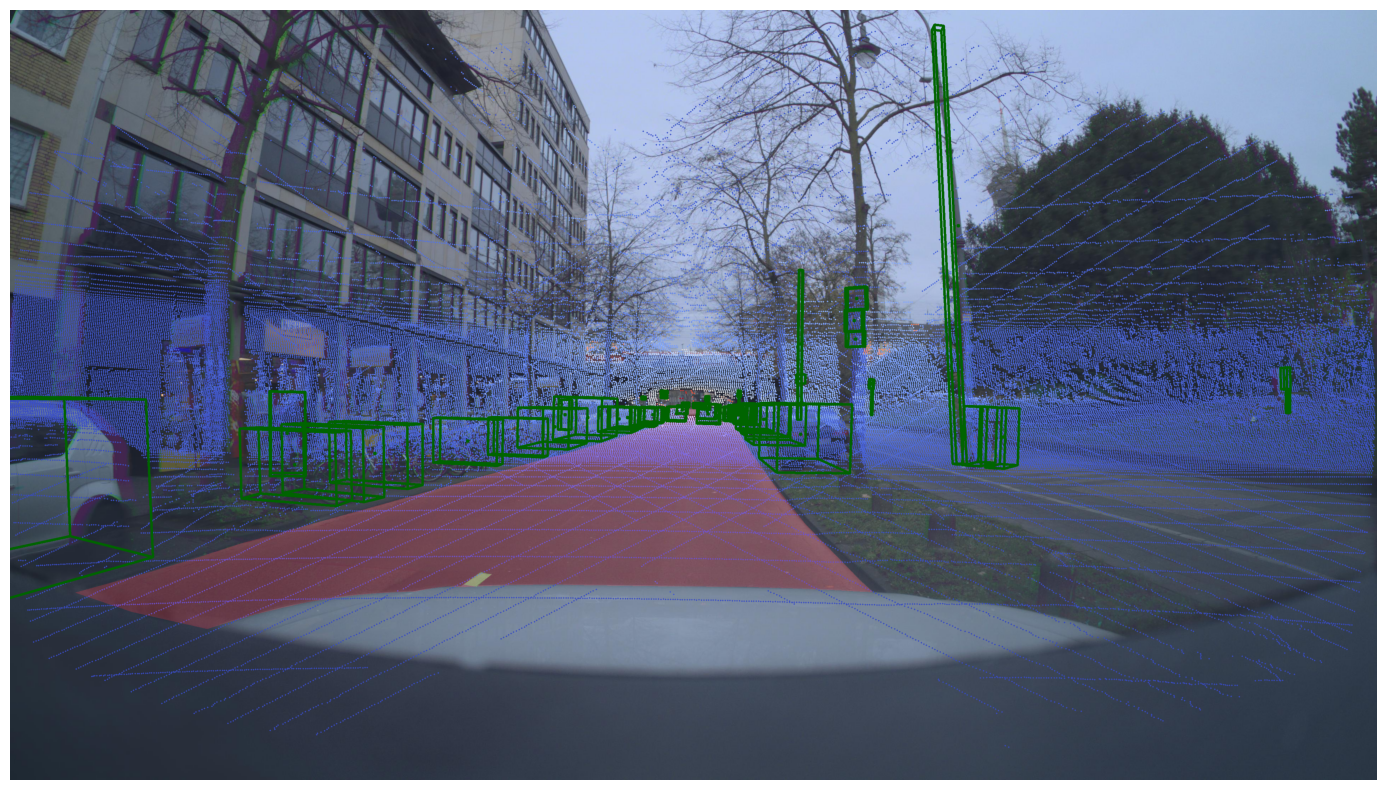

In [36]:
# we can also visualize all together
zod_frame = zod_frames[9158]

#pcd = zod_frame.get_aggregated_lidar(num_before=3) # NOTE! I use only core frames, not before (-1s) and after (+1s)
pcd = zod_frame.get_lidar()[0]
lane_annotations: List[LaneAnnotation] = zod_frame.get_annotation(AnnotationProject.LANE_MARKINGS)
ego_road_annotations: List[EgoRoadAnnotation] = zod_frame.get_annotation(AnnotationProject.EGO_ROAD)
object_annotations: List[ObjectAnnotation] = zod_frame.get_annotation(AnnotationProject.OBJECT_DETECTION)

ego_road_mask = polygons_to_binary_mask([anno.geometry for anno in ego_road_annotations])
lane_mask = polygons_to_binary_mask([anno.geometry for anno in lane_annotations])
calibrations = zod_frame.calibration
image = zod_frame.get_image(Anonymization.BLUR)

# overlay the mask/annotation/pointcloud on the image
image = visualize_lidar_on_image(pcd, calibrations, image)
image = overlay_mask_on_image(ego_road_mask, image, fill_color=(100, 0, 0), alpha=0.5)
image = overlay_mask_on_image(lane_mask, image, fill_color=(0, 100, 0), alpha=0.5)
for annotation in object_annotations:
    if annotation.box3d:
        image = overlay_object_3d_box_on_image(
            image, annotation.box3d, calibrations, color=(0, 100, 0), line_thickness=5
        )
plt.axis("off")
plt.imshow(image)
plt.show()

# ZodSequence
Visualization functionality for ZodFrames also works on sequences. Let's take a quick look.

### Fetch a ZodSequence
The ZodSequences class yeild a `ZodSequence` which acts a cache for the light-weight data (e.g., ego-motion, calibration, and metadata), but also holds an `info` attribute. This in turn holds all the paths to more heavy-weight data (e.g., images and point clouds) for all timesteps in the sequence. Note that annotations are only provided for a single frame, namely the `key_frame`.



In [ ]:
# We can do the same for the sequences
seq = zod_sequences[list(validation_sequences)[0]]

# Get the lidar frames
print(f"Number of lidar frames: {len(seq.info.get_lidar_frames(lidar=Lidar.VELODYNE))}")
# We can also get the original camera frames
print(f"Number of camera frames: {len(seq.info.get_camera_frames())}")

# Or see how long the sequence is
print(f"Timespan: {(seq.info.end_time - seq.info.start_time).total_seconds()}")

In [ ]:
from zod.visualization.lidar_on_image import visualize_lidar_on_image

# get the key frames
key_camera_frame = seq.info.get_key_camera_frame()

# get the annotations (when they are ready...)
try:
    annotations = seq.get_annotation(AnnotationProject.OBJECT_DETECTION)
except Exception:
    annotations = []

image = key_camera_frame.read()
pcd = seq.get_compensated_lidar(key_camera_frame.time)

image = visualize_lidar_on_image(
    pcd,
    seq.calibration,
    image,
)

for annotation in annotations:
    if annotation.box3d:
        image = overlay_object_3d_box_on_image(
            image, annotation.box3d, seq.calibration, color=(0, 100, 0), line_thickness=10
        )

plt.axis("off")
plt.imshow(image)
plt.show()

In [ ]:
# we can also visualize the entire sequence
draw_every_nth = 5  # (Only visualization every nth frame for speed...)

# get the mapping between camera and lidar frames
frames = seq.info.get_camera_lidar_map()

images = []
# iterate over the frames
for i, frame in enumerate(frames):
    if i % draw_every_nth == 0:
        camera_frame, lidar_frame = frame

        img = camera_frame.read()
        pcd = seq.get_compensated_lidar(camera_frame.time)

        lid_image = visualize_lidar_on_image(
            pcd,
            seq.calibration,
            img,
        )
        images.append(img)

In [ ]:
# Create a gif with all the frames (requires imageio)
import imageio
from IPython.core.display import Image

imageio.mimsave("test.gif", images, duration=0.2)
Image(filename="test.gif")